В данном ноутбуке представлены эксперименты с использованием классификатора `KNeighborsClassifier` и различными способами векторизации текста.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from gensim.models import word2vec
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import optuna


# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics
from word2vec_utils import Word2VecVectorizer, Word2VecTfIdfVectorizer

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
c:\Users\user\miniconda3\envs\ml_yp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [3]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


Xpreproc = X.release.apply(preprocessor)

Подберем параметры для алгоритма `KNeighborsClassifier` с помощью библиотеки optuna.

In [11]:
def objective(trial):

    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 1, 500),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'p': trial.suggest_float('p', 1, 2),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }
    
    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(Xpreproc).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )
    
    # отбор признаков по важности
    params['max_features'] = trial.suggest_int("max_features", 5, tf_idf.shape[1])
    selector = SelectFromModel(estimator, max_features=params["max_features"])

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", selector),
        (
            "model",
            KNeighborsClassifier(
                params['n_neighbors'], weights=params['weights'], p=params['p'], algorithm='brute',
            ),
        ),
    ])

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True, catch=(ValueError,))

Best trial: 105. Best value: 0.830994: 100%|██████████| 200/200 [00:23<00:00,  8.69it/s]


Подобранные оптимальные параметры:

In [12]:
study.best_params

{'C': 227.9952003597386,
 'n_neighbors': 2,
 'weights': 'distance',
 'p': 1.5832859727421138,
 'max_df': 0.9988197738954215,
 'min_df': 6,
 'max_features': 772}

Соберем итоговый пайплайн и посчитаем метрики:

              precision    recall  f1-score   support

        -1.0       0.73      0.83      0.78        23
         0.0       0.62      0.58      0.60        26
         1.0       0.78      0.74      0.76        19

    accuracy                           0.71        68
   macro avg       0.71      0.71      0.71        68
weighted avg       0.70      0.71      0.70        68



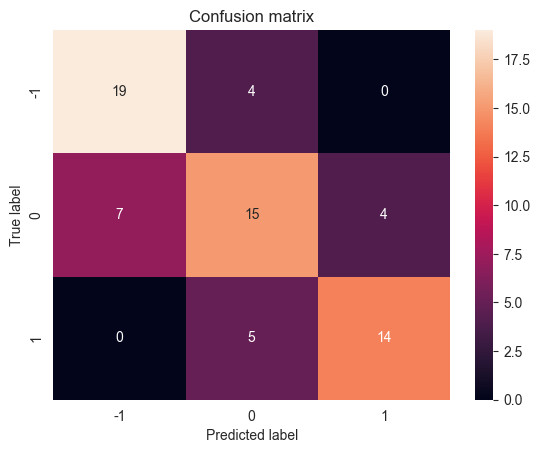

In [13]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

selector = SelectFromModel(estimator, max_features=study.best_params["max_features"])

classifier = KNeighborsClassifier(study.best_params['n_neighbors'],
                                  weights=study.best_params['weights'],
                                  p=study.best_params['p'],
                                  algorithm='brute')

pipeline = Pipeline([
    ("selector", selector),
    ("model", classifier),
])

metrics, model = calc_metrics(
    tf_idf, y,
    pipeline,
    name="K-neighbors tf_idf"
)

In [14]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.705882,0.710756,0.713284,0.711182,0.826925,0.830994


Теперь попробуем закодировать релизы с помощью `word2vec`. Подберем оптимальные параметры:

In [5]:
def objective(trial):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 1, 500),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'p': trial.suggest_float('p', 1, 2),
        'window': trial.suggest_int('window', 2, 20),
        'vector_size': trial.suggest_int('vector_size', 25, 200, step=25),
    }
    
    # векторизуем текст
    w2v = Word2VecVectorizer(window=params['window'], workers=1,
                             sg=1, vector_size=params['vector_size'], seed=RANDOM_STATE)
    embedings_w2v = w2v.fit_transform(Xpreproc.str.split())

    model = KNeighborsClassifier(
                params['n_neighbors'], weights=params['weights'], p=params['p'], algorithm='brute',
            )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(embedings_w2v, y, model, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True, catch=(ValueError,))

Best trial: 199. Best value: 0.785168: 100%|██████████| 200/200 [07:05<00:00,  2.13s/it]


In [6]:
study.best_params

{'C': 427.71498448440764,
 'n_neighbors': 2,
 'weights': 'uniform',
 'p': 1.1006198717322686,
 'window': 14,
 'vector_size': 150}

              precision    recall  f1-score   support

        -1.0       0.66      0.91      0.76        23
         0.0       0.54      0.58      0.56        26
         1.0       0.88      0.37      0.52        19

    accuracy                           0.63        68
   macro avg       0.69      0.62      0.61        68
weighted avg       0.67      0.63      0.62        68



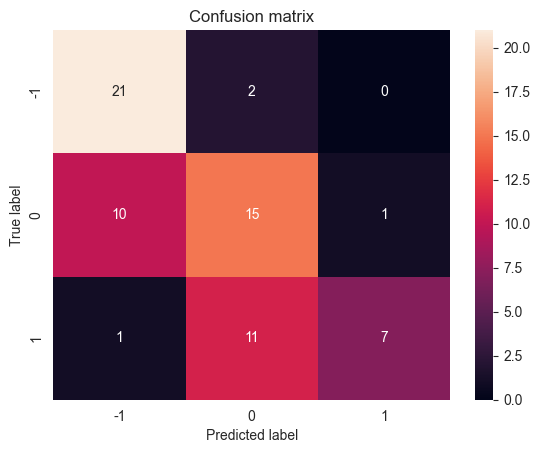

In [9]:
w2v = Word2VecVectorizer(preprocessor=preprocessor, window=study.best_params['window'],
                         workers=1, sg=1, vector_size=study.best_params['vector_size'], seed=RANDOM_STATE)
embedings_w2v = w2v.fit_transform(X.release)

classifier = KNeighborsClassifier(study.best_params['n_neighbors'],
                                  weights=study.best_params['weights'],
                                  p=study.best_params['p'],
                                  algorithm='brute')

metric, model = calc_metrics(
    embedings_w2v,
    y,
    classifier,
    name="K-neighbors word2vec",
)

In [15]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.705882,0.710756,0.713284,0.711182,0.826925,0.830994
K-neighbors word2vec,0.632353,0.612570,0.619463,0.688988,0.784025,0.785168


Результат получился хуже, чем при векторизации с помощью TF-IDF. Попробуем взвешивать вектора слов с учетом их важности, а не просто усреднять:

In [16]:
def objective(trial):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 1, 500),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'p': trial.suggest_float('p', 1, 2),
        'window': trial.suggest_int('window', 2, 20),
        'vector_size': trial.suggest_int('vector_size', 25, 200, step=25),
    }
    
    # векторизуем текст
    w2v = Word2VecTfIdfVectorizer(window=params['window'], workers=1,
                             sg=1, vector_size=params['vector_size'], seed=RANDOM_STATE)
    embedings_w2v = w2v.fit_transform(Xpreproc.str.split())

    model = KNeighborsClassifier(
                params['n_neighbors'], weights=params['weights'], p=params['p'], algorithm='brute',
            )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(embedings_w2v, y, model, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True, catch=(ValueError,))

Best trial: 56. Best value: 0.799397: 100%|██████████| 200/200 [05:28<00:00,  1.64s/it]


In [17]:
study.best_params

{'C': 219.73047995258327,
 'n_neighbors': 2,
 'weights': 'distance',
 'p': 1.4859490401060311,
 'window': 15,
 'vector_size': 75}

              precision    recall  f1-score   support

        -1.0       0.70      0.61      0.65        23
         0.0       0.54      0.73      0.62        26
         1.0       0.77      0.53      0.62        19

    accuracy                           0.63        68
   macro avg       0.67      0.62      0.63        68
weighted avg       0.66      0.63      0.63        68



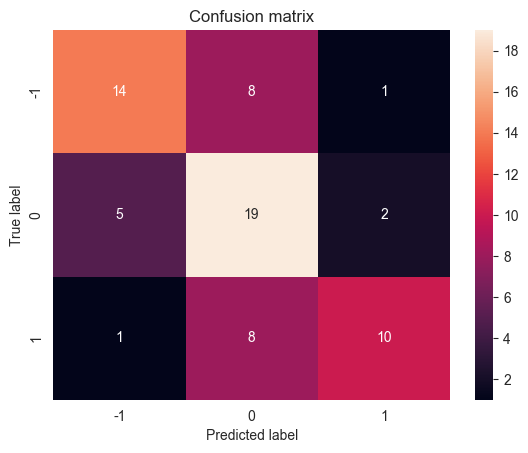

In [23]:
w2v = Word2VecTfIdfVectorizer(preprocessor=preprocessor, window=study.best_params['window'],
                         workers=1, sg=1, vector_size=study.best_params['vector_size'], seed=RANDOM_STATE)
embedings_w2v = w2v.fit_transform(X.release)

classifier = KNeighborsClassifier(study.best_params['n_neighbors'],
                                  weights=study.best_params['weights'],
                                  p=study.best_params['p'],
                                  algorithm='brute')

metric, model = calc_metrics(
    embedings_w2v,
    y,
    classifier,
    name="K-neighbors weighted word2vec",
)

In [24]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.705882,0.710756,0.713284,0.711182,0.826925,0.830994
K-neighbors word2vec,0.632353,0.612570,0.619463,0.688988,0.784025,0.785168
K-neighbors weighted word2vec,0.632353,0.633038,0.621927,0.670696,0.796332,0.799397


Взвешенный вариант word2vec дал более высокое качество, но незначительно. В целом, как и для линейных моделей, наилучшее качество показала векторизация с помощью TF-IDF с отбором признаков.